In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import auxiliary image maipulation libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Main pipeline class
from CloudSaturation import CloudSaturation

# Image plotting utils
from Utils import *
from MLUtils import *
import datetime
import time
import pickle

/Users/joosko/work/ijs/ml/SentinelHub/venv/lib/python3.6/site-packages/tifffile/tifffile.py:7685: UserWarning: No module named 'tifffile._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))


In [2]:
# Define bounding box of interest (Tulips field in netherlands in our case)
full_tulip_box = (52.85905593845727, 4.71038818359375, 52.91204098150524, 4.798278808593751)
# Initialize main pipeline object
# This object will hold all auxiliary data structures and methods needed for processing
# most importantly, all calls made for same CloudSaturation object could reuse same cloud detection data, 
# precomputed and stored in self.memo_data for downloaded data
netherlands_cloud = CloudSaturation(full_tulip_box, cloud_scale=6)

In [3]:
# Acquire first batch of data and cloud filter for corresponding space (determined by bounding box) 
# and time range (determined by constructor parameters)
mask_full, true_c_full, bands, dates_full, cloud_masks_full = \
    netherlands_cloud.get_cloud_saturation_mask()

Saved True color
Saved cloud detection bands
Saved bands
Downloaded data
Detecting clouds, this may take some time...
Cloud detection finished


In [4]:
field_2016, mask_2016, nonzero_2016 = netherlands_cloud.get_tulip_mask("tulip_field_2016")
field_2017, mask_2017, nonzero_2017 = netherlands_cloud.get_tulip_mask("tulip_field_2017")
#field_2018, mask_2018, nonzero_2018 = netherlands_cloud.get_tulip_mask("tulip_field_2018")
field_arra, mask_arra, nonzero_arra = netherlands_cloud.get_tulip_mask("arable_land_2017")
print(mask_2016.shape)

Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1904&height=589&width=590&srs=EPSG:3857&bbox=524358.0140363087,6956969.518615424,534141.9536568124,6966744.426812871
Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1905&height=589&width=590&srs=EPSG:3857&bbox=524358.0140363087,6956969.518615424,534141.9536568124,6966744.426812871
Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1917&height=589&width=590&srs=EPSG:3857&bbox=524358.0140363087,6956969.518615424,534141.9536568124,6966744.426812871
(589, 590)


In [5]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.naive_bayes import GaussianNB


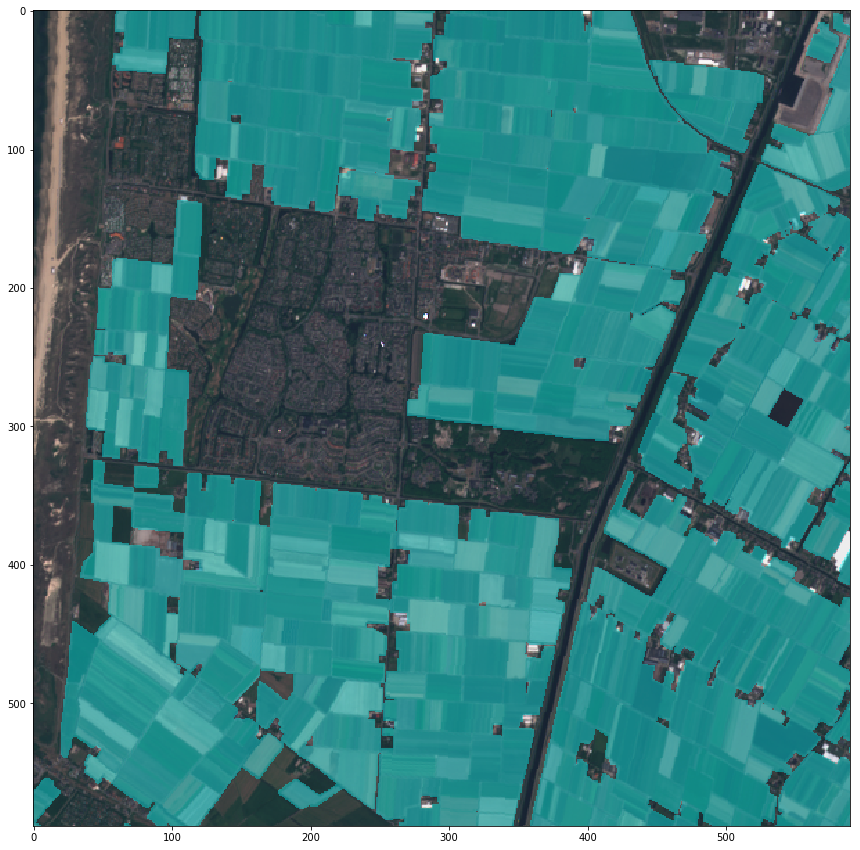

In [6]:
test_date = datetime.datetime(year=2016, month=5, day=2)
test_date = datetime.datetime(year=2017, month=5, day=18)
test_date_index = find_index_after_date(dates_full, test_date)
overlay_cloud_mask(true_c_full[test_date_index], mask_arra)

In [7]:
def ndvi(x):
    return (x[:,7] - x[:,3])/(x[:,7] + x[:,3])

def ndvi_nar(x):
    return (x[:,8] - x[:,3])/(x[:,8] + x[:,3])

def evi(x):
    return 2.5 * (x[:,7] - x[:,4]) / ((x[:,7] + 6.0 * x[:,3] - 7.5 * x[:,1]) + 1.0)

L = 0.5
def savi(x):
    return (x[:,7] - x[:,3]) / (x[:,7] + x[:,3] + L) * (1.0 + L)

def gvi(x):
    return -0.2848 * x[:,1] - 0.2435 * x[:,2] - 0.5436 * x[:,3] + 0.7243 * x[:,7] + 0.084 * x[:,11] - 0.18 *x[:,12]


In [8]:
# Add other indices
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier

test_date = datetime.datetime(year=2016, month=5, day=2)
#test_date = datetime.datetime(year=2017, month=5, day=18)
test_date_index = find_index_after_date(dates_full, test_date)

test_image_bands = bands[test_date_index]
reshaper = Reshaper(test_image_bands.shape)

X_flat = reshaper.flatten_data(test_image_bands)
Y_flat = reshaper.flatten_labels(mask_2016)

l, n = X_flat.shape
add_full = 1
if add_full:
    X_full_feature = np.zeros((l, n+3))
    X_full_feature[:, 0:13] = X_flat
    X_full_feature[:,13] = ndvi(X_flat)
    X_full_feature[:,14] = savi(X_flat)
    X_full_feature[:,15] = evi(X_flat)
    #X_full_feature[:,16] = gvi(X_flat)
else:
    X_full_feature = X_flat
print(sum(X_full_feature == 0))
clf = DecisionTreeClassifier()
NN = len(X_flat)
predicted = cross_val_predict(clf, X_full_feature[:NN], np.array([Y_flat[:NN]]).T, cv=3)

print("prec:", precision_score(Y_flat[:NN], predicted))
print("rec:", recall_score(Y_flat[:NN], predicted))
print("acc:", accuracy_score(Y_flat[:NN], predicted))
print("f1:", f1_score(Y_flat[:NN], predicted))


[ 0  0  0  0  0  0  0  0  0  0  0  0  0 11 11 18]
prec: 0.6222192220572131
rec: 0.6992885562074314
acc: 0.8762021236798941
f1: 0.6585065764929076


In [9]:
def prepare_data(test_date, y_mask, add_full=1):
    test_date_index = find_index_after_date(dates_full, test_date)

    test_image_bands = bands[test_date_index]
    reshaper = Reshaper(test_image_bands.shape)

    X_flat = reshaper.flatten_data(test_image_bands)
    Y_flat = reshaper.flatten_labels(y_mask)

    l, n = X_flat.shape
    if add_full:
        X_full_feature = np.zeros((l, n+3))
        X_full_feature[:, 0:13] = X_flat
        X_full_feature[:,13] = ndvi(X_flat)
        X_full_feature[:,14] = savi(X_flat)
        X_full_feature[:,15] = evi(X_flat)
        #X_full_feature[:,16] = gvi(X_flat)
    else:
        X_full_feature = X_flat
    return X_full_feature, Y_flat


def calculate_statistics(correct, predicted, verbose=True):
    stats = [(precision_score, "prec"), (recall_score, "rec"), (accuracy_score, "acc"), (f1_score,"f1")]
    results = []
    for func, name in stats:
        results.append(func(correct, predicted))
        if verbose:
            print(name + ":", results[-1])
    return tuple(results)


class_type = [
    ("Tulip fields in 2016", datetime.datetime(year=2016, month=5, day=2), mask_2016), 
    ("Tulip fields in 2017", datetime.datetime(year=2017, month=5, day=18), mask_2017), 
    ("Arable land in 2017", datetime.datetime(year=2017, month=5, day=18), mask_arra),
]

classifiers = [
    (AdaBoostClassifier,"Ada Boost"),
    (LogisticRegression, "Logistic Regression"),
    (DecisionTreeClassifier, "Decision Tree"),
    (RandomForestClassifier, "Random Forest"),
    (MLPClassifier, "Multi layer Perceptron",),
    (GradientBoostingClassifier, "Gradient Boosting"),
    (KNeighborsClassifier, "Nearest neighbours"),
    #(GaussianProcessClassifier, "Gaussian Process Classifier"),
    (GaussianNB, "Gaussian Naive Bayes")
]



file_name = "article-training-tresults2.pickle"
results_data = []
results_predicted = []
results_class = []

for name, date_i, mask_t in class_type:
    results_data.append([[], []])
    results_class.append([[], []])
    results_predicted.append([[], []])
    print("Testing:", name)
    for classifier, class_name, *kwargs in classifiers:
        print(class_name.title())
        for feature_eng in (0,1):
            print("Additional feature:", ["Off", "On"][feature_eng], end="....", flush=True)
            tt = time.time()
            X_full_feature, Y_flat = prepare_data(date_i, mask_t, feature_eng)
            
            if kwargs:
                kwargs = kwargs[0]
            else:
                kwargs = {}
            clf = classifier(**kwargs)
            predicted = cross_val_predict(clf, X_full_feature, Y_flat, cv=3)
            
            results_predicted[-1][feature_eng].append(predicted)
            results_class[-1][feature_eng].append(clf)
            
            timng = time.time() - tt
            print(timng)
            results_data[-1][feature_eng].append(calculate_statistics(Y_flat, predicted) + (timng,))
            
pickle.dump(
    (class_type,
     classifiers,
     results_data,
     results_predicted,
     results_class
    ), 
    open(file_name, "wb")
)
print("Finished")

Testing: Tulip fields in 2016
Ada Boost
Additional feature: Off....40.72012901306152
prec: 0.860016327271078
rec: 0.6393721761413447
acc: 0.9206814192397341
f1: 0.7334596863093973
Additional feature: On....58.92454504966736
prec: 0.8662627931525081
rec: 0.6364218760536786
acc: 0.9211706137952864
f1: 0.7337648453748516
Logistic Regression
Additional feature: Off....2.8204851150512695
prec: 0.8952516645203715
rec: 0.550846314653719
acc: 0.9123334580299848
f1: 0.6820368843476354
Additional feature: On....3.6114728450775146
prec: 0.876536737529162
rec: 0.5637433407512307
acc: 0.9119823889960001
f1: 0.6861745241881702
Decision Tree
Additional feature: Off....7.922683238983154
prec: 0.6404139298550007
rec: 0.6969451749949424
acc: 0.8814767920347616
f1: 0.6674847418219394
Additional feature: On....11.324686288833618
prec: 0.6289232731524363
rec: 0.698277024748803
acc: 0.8781761675922996
f1: 0.6617880852899587
Random Forest
Additional feature: Off....15.040565967559814
prec: 0.8698240278079513

In [19]:
header_template = r"""
\npdecimalsign{.}
\nprounddigits{3}
\begin{table}[ht]
\begin{tabular}{|l|c|n{1}{3}|n{1}{3}|n{1}{3}|n{1}{3}|c|}
\hline 
\textbf{Alg.} & \textbf{Ind} & \textbf{Prec} & \textbf{Rec} & \textbf{Acc} & \textbf{F1} & \textbf{T} \\ \hline \hline"""

line_template = r"""
\multirow{2}{*}{Logistic regression} & Yes & 0.01 & 0.02 & 0.03 & 0.04 \\ \cline{2-6}
                                     & No & 0.01 & 0.02 & 0.03 & 0.04 \\ \hline
"""

end_template = r"""
\end{tabular}
\caption{F:caption}
\label{F:label}
\end{table}
\npnoround
"""

replacers = [(r"Multi\\layer", "ML"), (r"Gaussian\\Naive", "Naive")]

c_type, classifiers, results_data, results_predicted, results_class = pickle.load(open(file_name, "rb"))

exclude_time = 0
round_digits = 10
round_time = 1
end = 7
if exclude_time:
    end = end - 1
    header_template = header_template.replace(r" & \textbf{T}", "")

for class_ind, (name, date_i, mask_t) in enumerate(class_type):
    result = header_template
    
    for classifier_ind, (classifier, class_name, *kwargs) in enumerate(classifiers):
        line_res = "\n" + r"\multirow{2}{*}{\shortstack[l]{" + r"\\".join(class_name.split()) + "}} & "
        
        dat = [j for j in results_data[class_ind][0][classifier_ind]]
        if exclude_time:
            dat.pop()
        dat[-1] = round(dat[-1], round_time)
        dat = [str(round(j, round_digits)) for j in dat]
        no_eng = "No & " + " & ".join(dat) + r"\\ \cline{2-"+ str(end) + "}" + "\n"
        
        dat = [j for j in results_data[class_ind][1][classifier_ind]]
        if exclude_time:
            dat.pop()
        dat[-1] = round(dat[-1], round_time)
        dat = [str(round(j, round_digits)) for j in dat]
        eng = " & Yes & " + " & ".join(dat) + r"\\ \hline"
        
        line_res = line_res + no_eng + eng
        
        result += line_res
        
    result = result + end_template.replace("F:caption", name + " results").replace("F:label", "tab:auto"+"".join(name.split()))
    for i,j in replacers:
        result = result.replace(i,j)
    print(result)
    print()



\npdecimalsign{.}
\nprounddigits{3}
\begin{table}[ht]
\begin{tabular}{|l|c|n{1}{3}|n{1}{3}|n{1}{3}|n{1}{3}|c|}
\hline 
\textbf{Alg.} & \textbf{Ind} & \textbf{Prec} & \textbf{Rec} & \textbf{Acc} & \textbf{F1} & \textbf{T} \\ \hline \hline
\multirow{2}{*}{\shortstack[l]{Ada\\Boost}} & No & 0.8600163273 & 0.6393721761 & 0.9206814192 & 0.7334596863 & 40.7\\ \cline{2-7}
 & Yes & 0.8662627932 & 0.6364218761 & 0.9211706138 & 0.7337648454 & 58.9\\ \hline
\multirow{2}{*}{\shortstack[l]{Logistic\\Regression}} & No & 0.8952516645 & 0.5508463147 & 0.912333458 & 0.6820368843 & 2.8\\ \cline{2-7}
 & Yes & 0.8765367375 & 0.5637433408 & 0.911982389 & 0.6861745242 & 3.6\\ \hline
\multirow{2}{*}{\shortstack[l]{Decision\\Tree}} & No & 0.6404139299 & 0.696945175 & 0.881476792 & 0.6674847418 & 7.9\\ \cline{2-7}
 & Yes & 0.6289232732 & 0.6982770247 & 0.8781761676 & 0.6617880853 & 11.3\\ \hline
\multirow{2}{*}{\shortstack[l]{Random\\Forest}} & No & 0.8698240278 & 0.6749949423 & 0.9272826681 & 0.7601237826 & 

In [24]:
last_date = class_type[-1][1]
last_date_ind = find_index_after_date(dates_full, last_date)
last_pred = results_predicted[2][1][4]

def revert(data):
    return reshaper.revert_labels_shape(data)

true_pos = last_pred & Y_flat
false_pos = (last_pred == 1) & (Y_flat == 0)
false_neg = (last_pred == 0) & (Y_flat == 1)
testing_true_c = true_c_full[date_ind]

overlay_cloud_mask(testing_true_c, [revert(true_pos) , revert(false_pos), revert(false_neg)], 
                   mask_maps=[[128,0,128], [0, 0,255], [255,0,0]],figsize=(11,11))
plt.savefig(f"may_classification_ar_land.png", bbox_inches='tight', pad_inches=0)
predicted = last_pred
print("prec:", precision_score(Y_flat, predicted))
print("rec:", recall_score(Y_flat, predicted))
print("f1:", f1_score(Y_flat, predicted))

NameError: name 'date_ind' is not defined

In [130]:
a = r"""
\tn
\tt
"""
print(a)


\tn
\tt



In [116]:
import string    
class SafeFormat(object):
    def __init__(self, **kw):
        self.__dict = kw

    def __getitem__(self, name):
        return self.__dict.get(name, '{%s}' % name)



string.Formatter().vformat('{what} {man}', [], SafeFormat(man=2))

'{what} 2'

In [14]:
print("prec:", precision_score(Y_flat[:NN], predicted))
print("rec:", recall_score(Y_flat[:NN], predicted))
print("acc:", accuracy_score(Y_flat[:NN], predicted))
print("f1:", f1_score(Y_flat[:NN], predicted))

prec: 0.8738084391304721
rec: 0.91117116390379
acc: 0.8584702598486375
f1: 0.8920987681405833


In [96]:
pickle.dump("burek", open("art-result.pickle", "wb"))

TypeError: Required argument 'file' (pos 2) not found

In [32]:
iteration_num = 0
def evaluate(model, X_testing, Y_testing):
    predictions = model.predict(X_testing)
    precission = precision_score(Y_testing, predictions)
    recall = recall_score(Y_testing, predictions)
    f1 = f1_score(Y_testing, predictions)
    
    predictions_test = model.predict(X_test)
    precission_t = precision_score(Y_test, predictions_test)
    recall_t = recall_score(Y_test, predictions_test)
    f1_t = f1_score(Y_test, predictions_test)
    
    global iteration_num
    print(f"Iteration: \t\t{iteration_num} \t\tTest data:")
    iteration_num += 1 
    print(f"F1: \t\t\t{f1:.5f}\t\t{f1_t:5f}")
    print(f"Precission: \t\t{precission:.5f}\t\t{precission_t:5f}")
    print(f"Recall: \t\t{recall:.5f}\t\t{recall_t:5f}")
    return f1

# Initial param grid
param_grid = {
    "bootstrap": [True],
    "max_depth": [80, 90, 100, 110],
    "max_features": ["sqrt", "log2"],
    "min_samples_leaf": [3, 4, 5],
    "min_samples_split": [8, 10, 12],
    "n_estimators": [100, 200, 300]
}

test_image_bands = bands[test_date_index]
reshaper = Reshaper(test_image.shape)

X_flat = reshaper.flatten_data(test_image_bands)
Y_flat = reshaper.flatten_labels(mask_2016)

X_train, X_test, Y_train, Y_test = train_test_split(X_flat, Y_flat, train_size=0.5, shuffle=False)

random_forest = RandomForestClassifier()
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=2, scoring=evaluate)
grid_search.fit(X_flat, Y_flat)


/Users/joosko/work/ijs/ml/SentinelHub/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
Iteration: 		0 		Test data:
F1: 	

[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total= 3.3min
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
Iteration: 		2 		Test data:
F1: 			0.82046		0.962556
Precission: 		0.94092		0.995620
Recall: 		0.72734		0.931618
Iteration: 		4 		Test data:
F1: 			0.78651		0.892764
Precission: 		0.90265		0.972539
Recall: 		0.69684		0.825085
Iteration: 		6 		Test data:
F1: 			0.72651		0.818937
Precission: 		0.79817		0.880047
Recall: 		0.66665		0.765763
Iteration: 		5 		Test data:
F1: 			0.95421		0.892764
Precission: 		0.99555		0.972539
Recall: 		0.91617		0.825085
[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
Iteration: 		3 		Test data:
F1: 			0.96101		0.962556
Precissio

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.6min


Iteration: 		9 		Test data:
F1: 			0.95915		0.896696
Precission: 		0.99692		0.974263
Recall: 		0.92414		0.830570
[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
Iteration: 		7 		Test data:
F1: 			0.96093		0.821384
Precission: 		0.99585		0.881227
Recall: 		0.92838		0.769153
[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
Iteration: 		4 		Test data:
F1: 			0.78625		0.892996
Precission: 		0.90487		0.973346
Recall: 		0.69512		0.824900
Iteration: 		6 		Test data:
F1: 			0.81963		0.954840
Precission: 		0.93924		0.993932
Recall: 		0.72704		0.918706
Iteration: 		8 		Test data:
F1: 			0.72630		0.819213
Precission: 	

[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
Iteration: 		13 		Test data:
F1: 			0.94746		0.888287
Precission: 		0.99430		0.971358
Recall: 		0.90484		0.818305
[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
Iteration: 		8 		Test data:
F1: 			0.81932		0.955301
Precission: 		0.94020		0.994102
Recall: 		0.72598		0.919414
Iteration: 		12 		Test data:
F1: 			0.78560		0.893077
Precission: 		0.90625		0.973281
Recall: 		0.69330		0.825085
Iteration: 		12 		Test data:
F1: 			0.72657		0.815691
Precission: 		0.80161		0.881101
Recall: 		0.66437		0.759322
Iteration: 		13 		Test data:
F1: 			0.94868		0.815691
Precission: 		0.99336		0.881101
Recall: 		0.90785		0.759322
[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4,

Iteration: 		18 		Test data:
F1: 			0.72553		0.814898
Precission: 		0.80227		0.881703
Recall: 		0.66220		0.757504
Iteration: 		17 		Test data:
F1: 			0.94527		0.947545
Precission: 		0.99172		0.992111
Recall: 		0.90297		0.906810
[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
Iteration: 		15 		Test data:
F1: 			0.94717		0.887315
Precission: 		0.99515		0.971685
Recall: 		0.90360		0.816425
[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
Iteration: 		19 		Test data:
F1: 			0.94779		0.814898
Precission: 		0.99343		0.881703
Recall: 		0.90616		0.757504
[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min

Recall: 		0.89973		0.755193
[CV]  bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total= 3.0min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
Iteration: 		23 		Test data:
F1: 			0.96752		0.968828
Precission: 		0.99652		0.996708
Recall: 		0.94017		0.942465
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
Iteration: 		17 		Test data:
F1: 			0.96843		0.903519
Precission: 		0.99740		0.974980
Recall: 		0.94110		0.841818
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
Iteration: 		16 		Te

Precission: 		0.99648		0.884273
Recall: 		0.93165		0.771402
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total= 3.0min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
Iteration: 		20 		Test data:
F1: 			0.81912		0.954241
Precission: 		0.93824		0.993826
Recall: 		0.72684		0.917689
Iteration: 		26 		Test data:
F1: 			0.78555		0.892364
Precission: 		0.90302		0.971931
Recall: 		0.69512		0.824838
Iteration: 		26 		Test data:
F1: 			0.72616		0.818788
Precission: 		0.80084		0.881828
Recall: 		0.66422		0.764160
Iteration: 		21 		Test data:
F1: 			0.95235		0.954241
Precission: 		0.99341		0.993826
Recall: 		0.91455		0.917689
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=200

Iteration: 		25 		Test data:
F1: 			0.95589		0.819556
Precission: 		0.99516		0.882050
Recall: 		0.91961		0.765331
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 4.5min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
Iteration: 		31 		Test data:
F1: 			0.95345		0.955685
Precission: 		0.99353		0.994107
Recall: 		0.91647		0.920123
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
Iteration: 		25 		Test data:
F1: 			0.96137		0.822140
Precission: 		0.99588		0.882888
Recall: 		0.92917		0.769214
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total= 3.0min
[CV] bootstrap=True, max_depth=80, max_featu

[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
Recall: 		0.90504		0.909307
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total= 2.9min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
Iteration: 		29 		Test data:
F1: 			0.94901		0.815853
Precission: 		0.99342		0.880196
Recall: 		0.90841		0.760277
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total= 3.0min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
Iteration: 		34 		Test data:
F1: 			0.81747		0.947623
Precission: 		0.93804		0.991913
Recall: 		0.72436		0.907119
Iteration: 		34 		Test data:
F1: 			0.78439		0.886424
Precission: 		0.90414		0.971426
Recall: 		0.69265		0.815100
Iteration: 		30 		Test data:
F1: 

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 61.7min


Iteration: 		39 		Test data:
F1: 			0.94537		0.947670
Precission: 		0.99170		0.992312
Recall: 		0.90317		0.906872
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total= 2.9min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
Iteration: 		32 		Test data:
F1: 			0.72722		0.815993
Precission: 		0.80327		0.882054
Recall: 		0.66432		0.759137
Iteration: 		38 		Test data:
F1: 			0.78393		0.887207
Precission: 		0.90283		0.971470
Recall: 		0.69270		0.816394
Iteration: 		40 		Test data:
F1: 			0.72696		0.815861
Precission: 		0.80242		0.881538
Recall: 		0.66448		0.759291
Iteration: 		34 		Test data:
F1: 			0.81732		0.943128
Precission: 		0.93697		0.990971
Recall: 		0.72476		0.899692
Iteration: 		39 		Test data:
F1: 			0.94751		0.887207
Precission: 		0.99461		0.971470
Recall: 		0.90466		0.816394
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5

Recall: 		0.72729		0.942527
Iteration: 		44 		Test data:
F1: 			0.78673		0.903584
Precission: 		0.90357		0.974677
Recall: 		0.69664		0.842157
Iteration: 		38 		Test data:
F1: 			0.72869		0.827002
Precission: 		0.80025		0.883668
Recall: 		0.66888		0.777165
Iteration: 		43 		Test data:
F1: 			0.94358		0.884952
Precission: 		0.99395		0.971309
Recall: 		0.89806		0.812696
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 5.1min
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
Iteration: 		41 		Test data:
F1: 			0.94397		0.812897
Precission: 		0.99239		0.880149
Recall: 		0.90006		0.755193
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 5.2min
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
Iteration: 		41 		Test data:
F

[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
Iteration: 		45 		Test data:
F1: 			0.96181		0.898590
Precission: 		0.99666		0.974668
Recall: 		0.92932		0.833529
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total= 5.1min
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
Iteration: 		43 		Test data:
F1: 			0.95314		0.955001
Precission: 		0.99361		0.994066
Recall: 		0.91584		0.918891
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total= 3.4min
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
Iteration: 		48 		Test data:
F1: 			0.78542		0.892860
Precission: 		0.90455		0.973409
Recall: 		0.69401		0.824622
Iteration: 		40 		Test data:
F1: 			0.72864		0.823762
Precis

[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
Iteration: 		52 		Test data:
F1: 			0.78735		0.898109
Precission: 		0.90573		0.974506
Recall: 		0.69634		0.832820
Iteration: 		50 		Test data:
F1: 			0.72685		0.822544
Precission: 		0.80230		0.884024
Recall: 		0.66437		0.769060
Iteration: 		50 		Test data:
F1: 			0.81949		0.955001
Precission: 		0.93828		0.994066
Recall: 		0.72739		0.918891
Iteration: 		54 		Test data:
F1: 			0.78659		0.893464
Precission: 		0.90559		0.974029
Recall: 		0.69523		0.825208
Iteration: 		48 		Test data:
F1: 			0.72703		0.819295
Precission: 		0.80354		0.883706
Recall: 		0.66382		0.763636
Iteration: 		53 		Test data:
F1: 			0.96039		0.898109
Precission: 		0.99665		0.974506
Recall: 		0.92666		0.832820
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total= 5.1min
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, 

Recall: 		0.72623		0.909831
Iteration: 		58 		Test data:
F1: 			0.78511		0.888182
Precission: 		0.90433		0.972499
Recall: 		0.69366		0.817319
Iteration: 		54 		Test data:
F1: 			0.81853		0.947318
Precission: 		0.93958		0.992240
Recall: 		0.72512		0.906287
Iteration: 		55 		Test data:
F1: 			0.94709		0.949477
Precission: 		0.99208		0.992737
Recall: 		0.90600		0.909831
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total= 4.9min
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
Iteration: 		59 		Test data:
F1: 			0.94837		0.888182
Precission: 		0.99492		0.972499
Recall: 		0.90598		0.817319
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total= 4.9min
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
Iteration: 		55 		Test data:
F1

Precission: 		0.99237		0.880175
Recall: 		0.90069		0.756733
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
Iteration: 		59 		Test data:
F1: 			0.94538		0.947965
Precission: 		0.99153		0.992184
Recall: 		0.90332		0.907519
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total= 5.0min
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
Iteration: 		62 		Test data:
F1: 			0.78451		0.887172
Precission: 		0.90517		0.972130
Recall: 		0.69224		0.815871
Iteration: 		56 		Test data:
F1: 			0.72607		0.815400
Precission: 		0.80194		0.881210
Recall: 		0.66331		0.758737
Iteration: 		58 		Test data:
F1: 			0.81946		0.942832
Precission: 		0.94074		0.991066
Recall: 		0.72587		0.89907

Iteration: 		61 		Test data:
F1: 			0.96218		0.821007
Precission: 		0.99589		0.881654
Recall: 		0.93068		0.768166
[CV]  bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total= 1.5min
[CV] bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
Iteration: 		62 		Test data:
F1: 			0.82053		0.969183
Precission: 		0.93934		0.996873
Recall: 		0.72840		0.942989
Iteration: 		60 		Test data:
F1: 			0.78638		0.903830
Precission: 		0.90572		0.974384
Recall: 		0.69482		0.842804
Iteration: 		68 		Test data:
F1: 			0.82080		0.961789
Precission: 		0.94072		0.995352
Recall: 		0.72800		0.930416
Iteration: 		63 		Test data:
F1: 			0.96804		0.969183
Precission: 		0.99673		0.996873
Recall: 		0.94095		0.942989
[CV]  bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total= 4.4min
[CV] bootstrap=True, max_depth=90, max_features=log2, min_s

Recall: 		0.66483		0.768290
Iteration: 		65 		Test data:
F1: 			0.95952		0.897574
Precission: 		0.99638		0.973963
Recall: 		0.92530		0.832296
[CV]  bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total= 1.5min
[CV] bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
Iteration: 		65 		Test data:
F1: 			0.96101		0.821193
Precission: 		0.99572		0.881920
Recall: 		0.92864		0.768290
[CV]  bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
Iteration: 		73 		Test data:
F1: 			0.95374		0.955801
Precission: 		0.99370		0.994141
Recall: 		0.91688		0.920308
[CV]  bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 4.6min
[CV] bootstrap=True

[CV] bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
Iteration: 		71 		Test data:
F1: 			0.94841		0.888959
Precission: 		0.99453		0.971881
Recall: 		0.90638		0.819076
[CV]  bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
Iteration: 		77 		Test data:
F1: 			0.94910		0.815636
Precission: 		0.99361		0.880889
Recall: 		0.90841		0.759384
[CV]  bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
Iteration: 		70 		Test data:
F1: 			0.81907		0.955292
Precission: 		0.94058		0.994300
Recall: 		0.72537		0.919230
Iteration: 		70 		Test data:
F1: 			0.78703		0.893425
Prec

[CV] bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
Iteration: 		74 		Test data:
F1: 			0.81876		0.947916
Precission: 		0.94025		0.992482
Recall: 		0.72507		0.907180
Iteration: 		72 		Test data:
F1: 			0.78602		0.887780
Precission: 		0.90555		0.972408
Recall: 		0.69437		0.816703
Iteration: 		74 		Test data:
F1: 			0.72563		0.815296
Precission: 		0.79978		0.879931
Recall: 		0.66407		0.759507
Iteration: 		73 		Test data:
F1: 			0.94692		0.887780
Precission: 		0.99454		0.972408
Recall: 		0.90365		0.816703
[CV]  bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
Iteration: 		75 		Test data:
F1: 			0.94893		0.815296
Precission: 		0.99317		0.879931
Recall: 		0.90846		0.759507
[CV]  bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=5

Recall: 		0.72744		0.943020
Iteration: 		86 		Test data:
F1: 			0.78624		0.903470
Precission: 		0.90365		0.973958
Recall: 		0.69583		0.842496
Iteration: 		78 		Test data:
F1: 			0.72590		0.825033
Precission: 		0.79569		0.880728
Recall: 		0.66736		0.775963
Iteration: 		79 		Test data:
F1: 			0.96775		0.969137
Precission: 		0.99662		0.996743
Recall: 		0.94050		0.943020
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
Iteration: 		87 		Test data:
F1: 			0.96889		0.903470
Precission: 		0.99751		0.973958
Recall: 		0.94186		0.842496
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
Iteration: 		79 		Test data:
F

F1: 			0.96358		0.822065
Precission: 		0.99657		0.880250
Recall: 		0.93271		0.771094
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total= 3.2min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
Iteration: 		83 		Test data:
F1: 			0.95323		0.955408
Precission: 		0.99396		0.994334
Recall: 		0.91571		0.919414
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
Iteration: 		82 		Test data:
F1: 			0.82009		0.962278
Precission: 		0.94070		0.995552
Recall: 		0.72689		0.931156
Iteration: 		80 		Test data:
F1: 			0.78605		0.892759
Precission: 		0.90527		0.973126
Recall: 		0.69457		0.824653
Iteration: 		86 		Test data:
F1: 			0.72559		0.818603
Precission: 		0.79893		0.8809

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 152.7min


Iteration: 		84 		Test data:
F1: 			0.78553		0.896560
Precission: 		0.90357		0.974152
Recall: 		0.69477		0.830416
Iteration: 		86 		Test data:
F1: 			0.72485		0.820718
Precission: 		0.79656		0.880097
Recall: 		0.66498		0.768844
Iteration: 		85 		Test data:
F1: 			0.95956		0.896560
Precission: 		0.99638		0.974152
Recall: 		0.92537		0.830416
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total= 1.7min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
Iteration: 		87 		Test data:
F1: 			0.96144		0.820718
Precission: 		0.99583		0.880097
Recall: 		0.92934		0.768844
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total= 1.7min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
Iteration: 		82 		Test data:
F1: 			0.81875		0.955501
Prec

Iteration: 		91 		Test data:
F1: 			0.94515		0.947518
Precission: 		0.99137		0.991977
Recall: 		0.90304		0.906872
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
Iteration: 		89 		Test data:
F1: 			0.94741		0.886980
Precission: 		0.99450		0.971493
Recall: 		0.90459		0.815994
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
Iteration: 		100 		Test data:
F1: 			0.72487		0.814740
Precission: 		0.79852		0.879297
Recall: 		0.66367		0.759014
Iteration: 		96 		Test data:
F1: 			0.81866		0.954952
Precission: 		0.93812		0.994032
Recall: 		0.72618		0.918829
Iteration: 		90 		Test data:
F1: 			0.78730		0.894318

Iteration: 		104 		Test data:
F1: 			0.81885		0.947897
Precission: 		0.94009		0.992847
Recall: 		0.72532		0.906841
Iteration: 		105 		Test data:
F1: 			0.94558		0.947897
Precission: 		0.99211		0.992847
Recall: 		0.90322		0.906841
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total= 1.8min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
Iteration: 		92 		Test data:
F1: 			0.78433		0.887218
Precission: 		0.90313		0.971715
Recall: 		0.69315		0.816240
Iteration: 		96 		Test data:
F1: 			0.72673		0.815628
Precission: 		0.80200		0.881202
Recall: 		0.66437		0.759137
Iteration: 		93 		Test data:
F1: 			0.94731		0.887218
Precission: 		0.99469		0.971715
Recall: 		0.90423		0.816240
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total= 1.9min
[CV] bootstrap=True, max_depth=100, max_features=sqrt

Precission: 		0.93689		0.996645
Recall: 		0.72825		0.942835
Iteration: 		96 		Test data:
F1: 			0.78576		0.903576
Precission: 		0.90135		0.974575
Recall: 		0.69644		0.842219
Iteration: 		103 		Test data:
F1: 			0.94433		0.813176
Precission: 		0.99226		0.879924
Recall: 		0.90082		0.755840
[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total= 3.4min
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
Iteration: 		101 		Test data:
F1: 			0.96753		0.968993
Precission: 		0.99633		0.996645
Recall: 		0.94034		0.942835
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total= 1.7min
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
Iteration: 		97 		Test data:
F1: 			0.96897		0.903576
Precission: 		0.99756		0.974575
Recall: 		0.94196		0.84

Recall: 		0.94444		0.776364
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total= 5.3min
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
Iteration: 		105 		Test data:
F1: 			0.96239		0.822921
Precission: 		0.99621		0.884161
Recall: 		0.93079		0.769615
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total= 3.6min
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
Iteration: 		114 		Test data:
F1: 			0.81843		0.954767
Precission: 		0.93769		0.993668
Recall: 		0.72608		0.918798
Iteration: 		115 		Test data:
F1: 			0.95276		0.954767
Precission: 		0.99309		0.993668
Recall: 		0.91559		0.918798
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total= 1.7min
[CV] boo

[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total= 3.5min
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
Iteration: 		114 		Test data:
F1: 			0.81868		0.954962
Precission: 		0.93836		0.993802
Recall: 		0.72608		0.919045
Iteration: 		101 		Test data:
F1: 			0.95632		0.819621
Precission: 		0.99549		0.881383
Recall: 		0.92011		0.765948
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 5.2min
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
Iteration: 		105 		Test data:
F1: 			0.96096		0.821826
Precission: 		0.99598		0.881435
Recall: 		0.92831		0.769769
Iteration: 		104 		Test data:
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total= 3.5min
F1: 			

[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
Iteration: 		119 		Test data:
F1: 			0.94867		0.888316
Precission: 		0.99481		0.971602
Recall: 		0.90661		0.818182
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total= 3.4min
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
Iteration: 		111 		Test data:
F1: 			0.95562		0.819317
Precission: 		0.99532		0.882767
Recall: 		0.91898		0.764376
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total= 5.2min
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
Iteration: 		115 		Test data:
F1: 			0.94968		0.817036
Precission: 		0.99373		0.881421
Recall: 		0.90937		0.761418
[CV]  bootstrap=True, max_depth=100, max_features=log

Iteration: 		128 		Test data:
F1: 			0.78500		0.887620
Precission: 		0.90447		0.971981
Recall: 		0.69340		0.816733
Iteration: 		108 		Test data:
F1: 			0.72586		0.814826
Precission: 		0.80011		0.879828
Recall: 		0.66422		0.758767
Iteration: 		129 		Test data:
F1: 			0.94754		0.887620
Precission: 		0.99466		0.971981
Recall: 		0.90469		0.816733
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total= 3.3min
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
Iteration: 		114 		Test data:
F1: 			0.72570		0.815044
Precission: 		0.80039		0.880047
Recall: 		0.66377		0.758983
Iteration: 		124 		Test data:
F1: 			0.81789		0.942547
Precission: 		0.93762		0.990660
Recall: 		0.72527		0.898891
Iteration: 		109 		Test data:
F1: 			0.94829		0.814826
Precission: 		0.99322		0.879828
Recall: 		0.90724		0.758767
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_sampl

F1: 			0.81959		0.969409
Precission: 		0.93923		0.996939
Recall: 		0.72699		0.943359
Iteration: 		128 		Test data:
F1: 			0.78455		0.902957
Precission: 		0.90517		0.974953
Recall: 		0.69229		0.840863
Iteration: 		124 		Test data:
F1: 			0.72785		0.826212
Precission: 		0.79889		0.882742
Recall: 		0.66842		0.776487
Iteration: 		123 		Test data:
F1: 			0.96803		0.969409
Precission: 		0.99660		0.996939
Recall: 		0.94105		0.943359
[CV]  bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total= 3.4min
[CV] bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
Iteration: 		119 		Test data:
F1: 			0.94363		0.813301
Precission: 		0.99216		0.880553
Recall: 		0.89963		0.755593
[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 5.1min
[CV] bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_sa

Precission: 		0.99693		0.974399
Recall: 		0.92889		0.833929
[CV]  bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total= 4.4min
[CV] bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
Iteration: 		129 		Test data:
F1: 			0.95310		0.954877
Precission: 		0.99334		0.993834
Recall: 		0.91599		0.918860
[CV]  bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total= 2.9min
[CV] bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
Iteration: 		138 		Test data:
F1: 			0.78503		0.892801
Precission: 		0.90465		0.973440
Recall: 		0.69335		0.824499
Iteration: 		116 		Test data:
F1: 			0.72748		0.822266
Precission: 		0.80163		0.883340
Recall: 		0.66589		0.769091
Iteration: 		139 		Test data:
F1: 			0.95501		0.892801
Precission: 		0.99594		0.973440
Recall: 		0.91731		0

Iteration: 		142 		Test data:
F1: 			0.78730		0.898056
Precission: 		0.90628		0.974675
Recall: 		0.69593		0.832604
Iteration: 		143 		Test data:
F1: 			0.96060		0.898056
Precission: 		0.99671		0.974675
Recall: 		0.92702		0.832604
[CV]  bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total= 4.3min
[CV] bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
Iteration: 		136 		Test data:
F1: 			0.72679		0.821596
Precission: 		0.79856		0.881188
Recall: 		0.66685		0.769553
Iteration: 		130 		Test data:
F1: 			0.81902		0.955320
Precission: 		0.93823		0.994037
Recall: 		0.72668		0.919507
Iteration: 		128 		Test data:
F1: 			0.78644		0.893154
Precission: 		0.90685		0.974152
Recall: 		0.69426		0.824592
Iteration: 		124 		Test data:
F1: 			0.72704		0.819551
Precission: 		0.80223		0.882818
Recall: 		0.66473		0.764746
Iteration: 		131 		Test data:
F1: 			0.95334		0.955320
Precission:

F1: 			0.78462		0.888655
Precission: 		0.90390		0.972455
Recall: 		0.69315		0.818151
Iteration: 		136 		Test data:
F1: 			0.81833		0.948354
Precission: 		0.93914		0.992190
Recall: 		0.72507		0.908228
Iteration: 		135 		Test data:
F1: 			0.94669		0.949329
Precission: 		0.99221		0.992669
Recall: 		0.90517		0.909615
[CV]  bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total= 4.3min
[CV] bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
Iteration: 		141 		Test data:
F1: 			0.94915		0.888655
Precission: 		0.99515		0.972455
Recall: 		0.90722		0.818151
[CV]  bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total= 4.3min
[CV] bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
Iteration: 		137 		Test data:
F1: 			0.94596		0.948354
Precission: 		0.99157		0.9

Precission: 		0.99168		0.879042
Recall: 		0.89839		0.755624
[CV]  bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
Iteration: 		141 		Test data:
F1: 			0.94565		0.947958
Precission: 		0.99162		0.992316
Recall: 		0.90375		0.907396
[CV]  bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total= 4.9min
[CV] bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
Iteration: 		152 		Test data:
F1: 			0.78530		0.888074
Precission: 		0.90536		0.972633
Recall: 		0.69335		0.817042
Iteration: 		153 		Test data:
F1: 			0.94782		0.888074
Precission: 		0.99494		0.972633
Recall: 		0.90497		0.817042
[CV]  bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estim

[CV] bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
Iteration: 		145 		Test data:
F1: 			0.96243		0.822884
Precission: 		0.99616		0.883386
Recall: 		0.93091		0.770139
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total= 1.7min
[CV] bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
Iteration: 		132 		Test data:
F1: 			0.82046		0.969454
Precission: 		0.94151		0.997068
Recall: 		0.72699		0.943328
Iteration: 		150 		Test data:
F1: 			0.78677		0.904004
Precission: 		0.90513		0.975243
Recall: 		0.69578		0.842465
Iteration: 		138 		Test data:
F1: 			0.81977		0.962101
Precission: 		0.93937		0.995420
Recall: 		0.72719		0.930940
Iteration: 		133 		Test data:
F1: 			0.96805		0.969454
Precission: 		0.99673		0.997068
Recall: 		0.94098		0.943328
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_sampl

F1: 			0.78566		0.897313
Precission: 		0.90537		0.974914
Recall: 		0.69391		0.831156
Iteration: 		148 		Test data:
F1: 			0.72711		0.821693
Precission: 		0.80146		0.883076
Recall: 		0.66539		0.768290
Iteration: 		147 		Test data:
F1: 			0.96060		0.897313
Precission: 		0.99676		0.974914
Recall: 		0.92697		0.831156
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
Iteration: 		149 		Test data:
F1: 			0.96046		0.821693
Precission: 		0.99585		0.883076
Recall: 		0.92750		0.768290
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
Iteration: 		143 		Test data:
F1: 			0.95323		0.955323
Precission: 		0.99402		0.9943

Precission: 		0.80152		0.881347
Recall: 		0.66215		0.757904
Iteration: 		153 		Test data:
F1: 			0.94573		0.947914
Precission: 		0.99173		0.992183
Recall: 		0.90380		0.907427
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
Iteration: 		149 		Test data:
F1: 			0.94757		0.887304
Precission: 		0.99441		0.971441
Recall: 		0.90494		0.816579
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total= 1.6min
[CV] bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
Iteration: 		161 		Test data:
F1: 			0.94873		0.814978
Precission: 		0.99328		0.881347
Recall: 		0.90800		0.757904
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estim

[CV] bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
Iteration: 		153 		Test data:
F1: 			0.94526		0.947692
Precission: 		0.99131		0.991881
Recall: 		0.90330		0.907273
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total= 1.7min
[CV] bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
Iteration: 		150 		Test data:
F1: 			0.81825		0.948364
Precission: 		0.94055		0.991991
Recall: 		0.72410		0.908413
Iteration: 		154 		Test data:
F1: 			0.78461		0.887649
Precission: 		0.90363		0.972226
Recall: 		0.69330		0.816610
Iteration: 		158 		Test data:
F1: 			0.72505		0.814828
Precission: 		0.79800		0.879090
Recall: 		0.66432		0.759322
Iteration: 		155 		Test data:
F1: 			0.94735		0.887649
Precission: 		0.99494		0.972226
Recall: 		0.90411		0.816610
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_sampl

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 279.3min


Iteration: 		164 		Test data:
F1: 			0.72761		0.816382
Precission: 		0.80319		0.881966
Recall: 		0.66503		0.759877
Iteration: 		144 		Test data:
F1: 			0.81889		0.947429
Precission: 		0.93991		0.991710
Recall: 		0.72547		0.906934
Iteration: 		160 		Test data:
F1: 			0.78449		0.887836
Precission: 		0.90371		0.972062
Recall: 		0.69305		0.817042
Iteration: 		154 		Test data:
F1: 			0.72724		0.816080
Precission: 		0.80243		0.881386
Recall: 		0.66493		0.759784
Iteration: 		145 		Test data:
F1: 			0.94512		0.947429
Precission: 		0.99128		0.991710
Recall: 		0.90307		0.906934
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total= 3.1min
[CV] bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
Iteration: 		161 		Test data:
F1: 			0.94791		0.887836
Precission: 		0.99483		0.972062
Recall: 		0.90522		0.817042
[CV]  bootstrap=True, max_depth=110, max_features=log2, min_sampl

[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 286.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function evaluate at 0x127fd0ea0>, verbose=2)

In [7]:
try:
    best_params = grid_search.best_params_
except NameError:
    best_params = {'bootstrap': True,
 'max_depth': 80,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [19]:
best_params = {'bootstrap': True,
 'max_depth': 80,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [ ]:
# Add other indices

test_image_bands = bands[test_date_index]
reshaper = Reshaper(test_image_bands.shape)

X_flat = reshaper.flatten_data(test_image_bands)
Y_flat = reshaper.flatten_labels(mask_arra)

l, n = X_flat.shape
X_full_feature = np.zeros((l, n+3))
X_full_feature[:, 0:13] = X_flat
X_full_feature[:,13] = ndvi(X_flat)
X_full_feature[:,14] = savi(X_flat)
X_full_feature[:,15] = evi(X_flat)
print(sum(X_full_feature == 0))
clf = RandomForestClassifier()
predicted = cross_val_predict(clf, X_full_feature, Y_flat, cv=3)

print("prec:", precision_score(Y_flat, predicted))
print("rec:", recall_score(Y_flat, predicted))
print("acc:", accuracy_score(Y_flat, predicted))
print("f1:", f1_score(Y_flat, predicted))


[ 0  0  0  0  0  0  0  0  0  0  0  0  0 14 13 29]


In [26]:
test_image_bands = bands[test_date_index]
reshaper = Reshaper(test_image_bands.shape)

X_flat = reshaper.flatten_data(test_image_bands)
Y_flat = reshaper.flatten_labels(mask_2016)

X_train, X_test, Y_train, Y_test = train_test_split(X_flat, Y_flat, train_size=0.5, shuffle=False)

l, n = X_flat.shape

X_full_feature = np.zeros((l, n+1))

from sklearn.model_selection import cross_val_predict
clf = RandomForestClassifier(**best_params) # Better but quite slow
clf = RandomForestClassifier()
predicted = cross_val_predict(clf, X_flat, Y_flat, cv=3)


/Users/joosko/work/ijs/ml/SentinelHub/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [22]:
print("prec:", precision_score(Y_flat, predicted))
print("rec:", recall_score(Y_flat, predicted))
print("acc:", accuracy_score(Y_flat, predicted))
print("f1:", f1_score(Y_flat, predicted))

prec: 0.879567328166255
rec: 0.6964056915503406
acc: 0.9319041178671117
f1: 0.7773428678961234


In [24]:
print("prec:", precision_score(Y_flat, predicted))
print("rec:", recall_score(Y_flat, predicted))
print("acc:", accuracy_score(Y_flat, predicted))
print("f1:", f1_score(Y_flat, predicted))

prec: 0.8667229473775353
rec: 0.6750286600579944
acc: 0.9268136168743345
f1: 0.7589586117350469


In [18]:
from sklearn.model_selection import cross_val_predict

testing_dates = [(2016, 3, 12), (2016, 4,1), (2016, 4,11), (2016, 4, 21), (2016,5, 1), (2016, 5, 11)]

testing_dates = list(map(lambda x: datetime.datetime(year=x[0], month=x[1], day=x[2]), 
                         testing_dates))

classifiers = []
predictions = []
for date in testing_dates:
    print("start", date)
    date_ind = find_index_after_date(dates_full, date)
    image = bands[date_ind]
    X_flat = reshaper.flatten_data(image)
    Y_flat = reshaper.flatten_labels(mask_2016)
    clf = RandomForestClassifier(**best_params)
    classifiers.append(clf)
    predicted = cross_val_predict(clf, X_flat, Y_flat, cv=3)
    predictions.append(predicted)
    print("prec:", precision_score(Y_flat, predicted))
    print("rec:", recall_score(Y_flat, predicted))
    print("f1:", f1_score(Y_flat, predicted))

start 2016-03-12 00:00:00


NameError: name 'best_params' is not defined

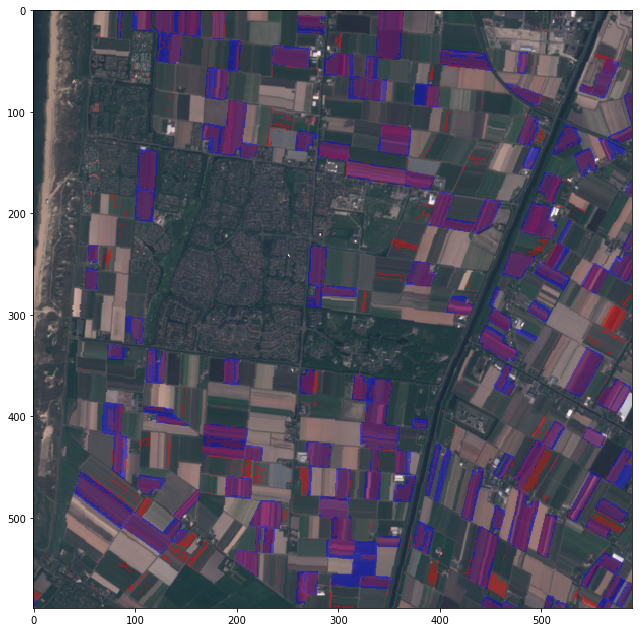

In [37]:
last_prediction = predictions[-1]
def revert(data):
    return reshaper.revert_labels_shape(data)
true_pos = last_prediction & Y_flat
false_pos = (last_prediction == 1) & (Y_flat == 0)
false_neg = (last_prediction == 0) & (Y_flat == 1)
testing_true_c = true_c_full[find_index_after_date(dates_full,testing_dates[-1])]

overlay_cloud_mask(testing_true_c, [revert(true_pos) , revert(false_pos), revert(false_neg)], 
                   mask_maps=[[128,0,128], [255, 0,0], [0,0,255]],figsize=(11,11))
plt.savefig(f"may_classification.png", bbox_inches='tight', pad_inches=0)

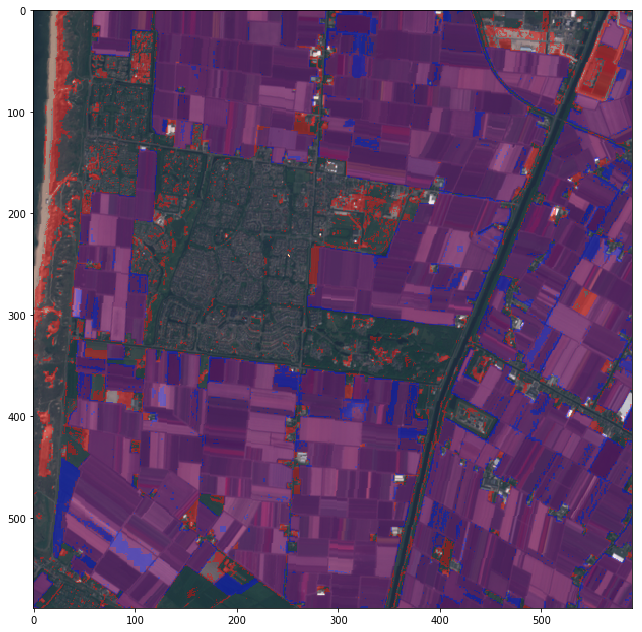

In [39]:
clf = RandomForestClassifier(**best_params)

date_ind = find_index_after_date(dates_full,testing_dates[-1])
image = bands[date_ind]

X_flat = reshaper.flatten_data(image)
Y_flat = reshaper.flatten_labels(mask_arra)

last_pred = cross_val_predict(clf, X_flat, Y_flat, cv=3)


prec: 0.9067918561682774
rec: 0.9149804828423793
f1: 0.9108677661062394


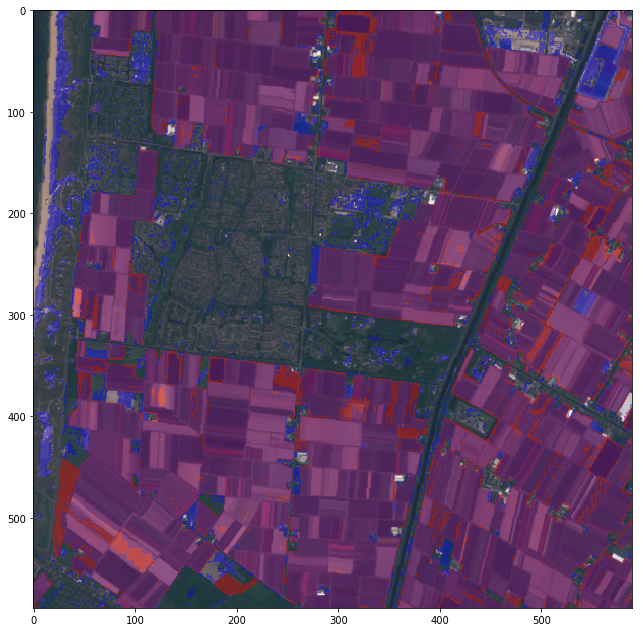

In [42]:
def revert(data):
    return reshaper.revert_labels_shape(data)

true_pos = last_pred & Y_flat
false_pos = (last_pred == 1) & (Y_flat == 0)
false_neg = (last_pred == 0) & (Y_flat == 1)
testing_true_c = true_c_full[date_ind]

overlay_cloud_mask(testing_true_c, [revert(true_pos) , revert(false_pos), revert(false_neg)], 
                   mask_maps=[[128,0,128], [0, 0,255], [255,0,0]],figsize=(11,11))
plt.savefig(f"may_classification_ar_land.png", bbox_inches='tight', pad_inches=0)
predicted = last_pred
print("prec:", precision_score(Y_flat, predicted))
print("rec:", recall_score(Y_flat, predicted))
print("f1:", f1_score(Y_flat, predicted))

In [43]:
from sklearn.model_selection import cross_val_predict

testing_dates = [(2016, 3, 12), (2016, 4,1), (2016, 4,11), (2016, 4, 21), (2016,5, 1), (2016, 5, 11)]

testing_dates = list(map(lambda x: datetime.datetime(year=x[0], month=x[1], day=x[2]), 
                         testing_dates))0

classifiers_ara = []
predictions_ara = []
for date in testing_dates:
    print("start", date)
    date_ind = find_index_after_date(dates_full, date)
    image = bands[date_ind]
    X_flat = reshaper.flatten_data(image)
    Y_flat = reshaper.flatten_labels(mask_arra)
    clf = RandomForestClassifier(**best_params)
    classifiers_ara.append(clf)
    predicted = cross_val_predict(clf, X_flat, Y_flat, cv=3)
    predictions_ara.append(predicted)
    print("prec:", precision_score(Y_flat, predicted))
    print("rec:", recall_score(Y_flat, predicted))
    print("f1:", f1_score(Y_flat, predicted))

start 2016-03-12 00:00:00
prec: 0.9393351723627208
rec: 0.909526434432658
f1: 0.924190503947012
start 2016-04-01 00:00:00
prec: 0.922310544364475
rec: 0.890739769737874
f1: 0.9062502849743296
start 2016-04-11 00:00:00
prec: 0.9162696860890895
rec: 0.9240511434679143
f1: 0.9201439635494646
start 2016-04-21 00:00:00
prec: 0.8917256435262645
rec: 0.8933121804093449
f1: 0.8925182069129179
start 2016-05-01 00:00:00
prec: 0.8826293955995869
rec: 0.9039379394721628
f1: 0.8931565931085482
start 2016-05-11 00:00:00
prec: 0.9068396592820777
rec: 0.9155854923208612
f1: 0.9111915901397332
